In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 1

In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward(retain_graph=True)
            dis_optimizer.step() 
            all_a = 1/(dis_error_real+1)
            
            #generate children from population
            child,a_gen = gen_children(population,device,gen,batch_size,a = all_a)
            
            #train discriminator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            
            #define generator loss
            exploration = torch.std(dis_out_f)
            gen_error_exploration = -dis_error_real#-exploration
            
            gen_error_exploitation = -torch.mean(dis_out_f) #+ torch.mean(a_gen)
            gen_error = gen_error_exploration + gen_error_exploitation
            
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph   
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real)  
    #print(rank)
    #print(dis_out_r)
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all


starting training
142
Measured population fitness : 0s
population fitness : [  8.  10. 376.  10.   8.   8.  10.   9.   9.  10.]
mean fit : 45.8
Trained GAN : 1s
Evolved : 0s


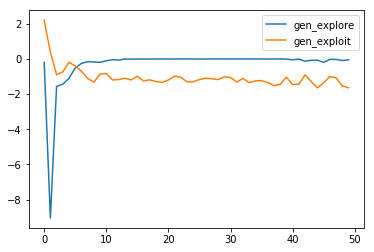

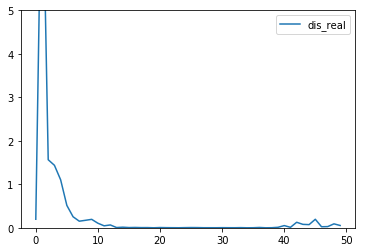

Generation 1  fitness : 376.0
#################################
Measured population fitness : 0s
population fitness : [ 8.  9. 10.  9. 30. 37. 10.  9. 10.  9.]
mean fit : 14.1
Trained GAN : 2s
Evolved : 0s


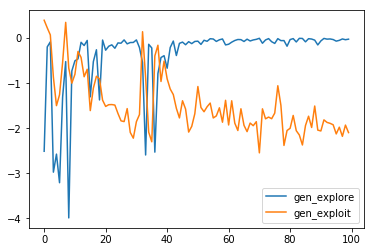

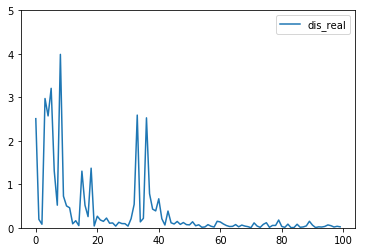

Generation 2  fitness : 37.0
#################################
Measured population fitness : 0s
population fitness : [ 10. 244.  10.   9.   8.  22.   9.  10.  11.   9.]
mean fit : 34.2
Trained GAN : 1s
Evolved : 0s


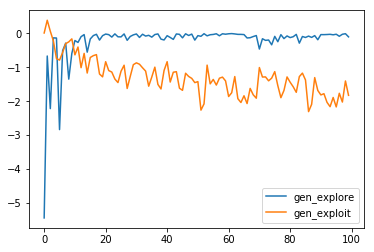

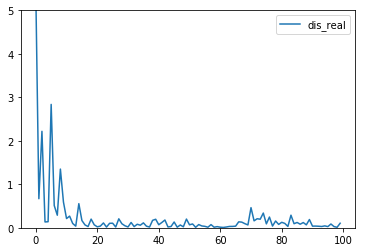

Generation 3  fitness : 244.0
#################################
Measured population fitness : 0s
population fitness : [ 8. 70. 13.  8. 15.  9.  9. 10. 10. 10.]
mean fit : 16.2
Trained GAN : 2s
Evolved : 0s


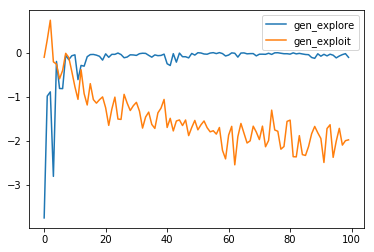

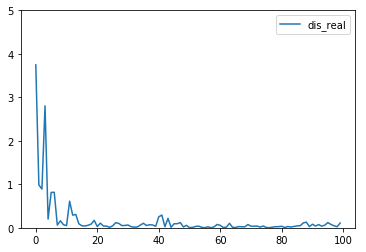

Generation 4  fitness : 70.0
#################################
Measured population fitness : 0s
population fitness : [11. 15. 10.  9. 10.  9. 25. 20.  8. 13.]
mean fit : 13.0
Trained GAN : 1s
Evolved : 0s


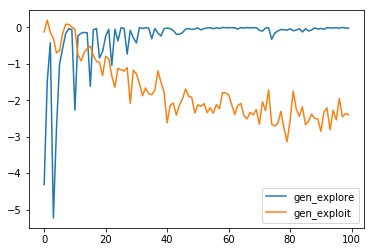

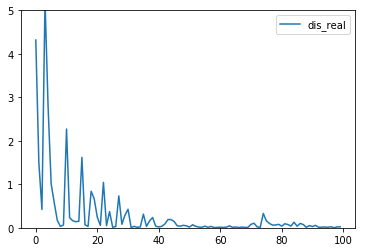

Generation 5  fitness : 25.0
#################################
Measured population fitness : 0s
population fitness : [11. 13. 10.  9. 10.  9. 11. 11. 10. 12.]
mean fit : 10.6
Trained GAN : 2s
Evolved : 0s


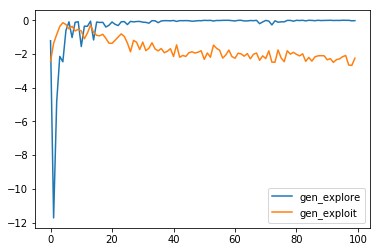

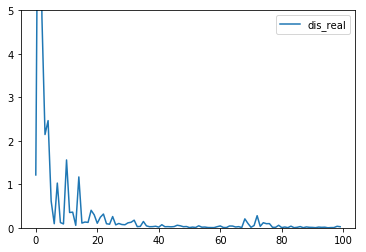

Generation 6  fitness : 13.0
#################################
Measured population fitness : 0s
population fitness : [2000.    8.   16.   15.   10.   96.   85.  136.   10.  130.]
mean fit : 250.6
Trained GAN : 2s
Evolved : 0s


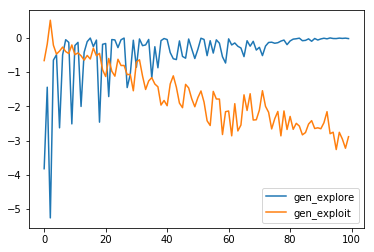

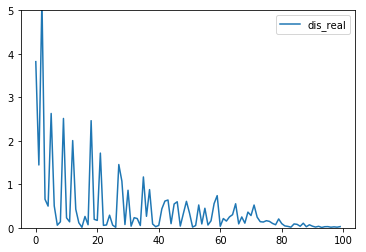

Generation 7  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [10. 21. 15. 19. 38. 17. 20. 21. 12. 32.]
mean fit : 20.5
Trained GAN : 2s
Evolved : 0s


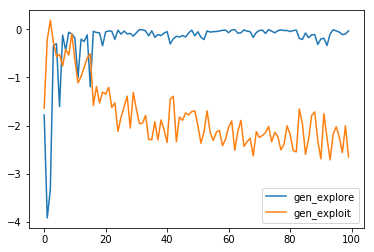

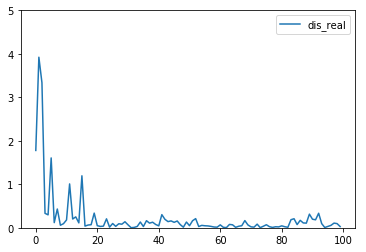

Generation 8  fitness : 38.0
#################################
Measured population fitness : 1s
population fitness : [  10.   13. 2000.  573. 2000.  565.  111. 2000.  132.  198.]
mean fit : 760.2
Trained GAN : 2s
Evolved : 0s


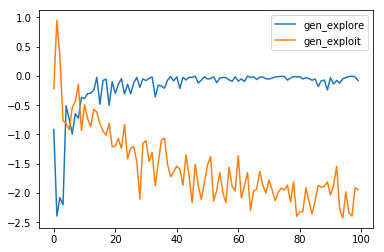

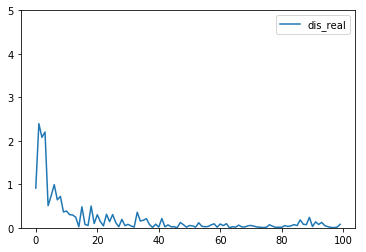

Generation 9  fitness : 2000.0
#################################
Measured population fitness : 1s
population fitness : [  95.  201. 2000.  131.  109. 2000.   39.  120.  102.  318.]
mean fit : 511.5
Trained GAN : 2s
Evolved : 0s


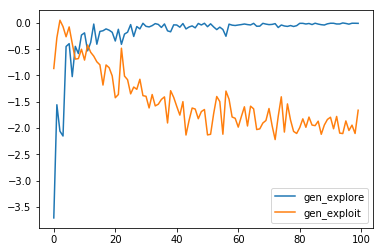

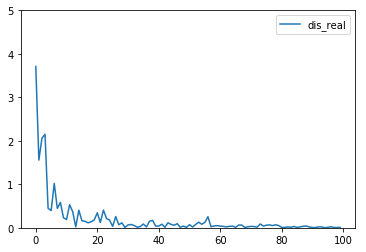

Generation 10  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [166.  78.  84. 197.  72.  12.  16.  25.  13. 152.]
mean fit : 81.5


In [ ]:
population_size = 10
max_population = population_size
max_population_batch = 2
out_size = population_size
n_generations = 300

#randomly inititialise starting population
population = []
for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    
    #all_a *= 0.9
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.5,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    #fitness_batch = np.minimum(0,fitness_batch)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss = train_gan(population_batch,fitness_batch,
              batch_size =5,n_epochs = 25)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0#.1
    mutation_rate = 0#.3
    mutation_rate = np.random.choice([0.1, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
#env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 50000)
print(fitness)

In [ ]:
yeet = torch.rand([1,10])
print(torch.clamp(yeet,0,0.5))

In [ ]:
print(len(list(torch.zeros([5,3]).shape)))